In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

matmul_gpu_sim = pd.read_csv(
    "matmul_RTX4090_sim.csv", header=None, names=["M", "N", "K", "latency", "throughput", "power", "total", "memory_to_l2_transfer", "l2_to_l1_transfer", "l1_to_l0_transfer", "compute"]
)
matmul_gpu_sim["throughput"] = (
    matmul_gpu_sim["throughput"].str.extract(r"(\d+\.?\d*)").astype(float)
)
matmul_gpu_sim.set_index(["M", "N", "K"], inplace=True)

color_NV = sns.color_palette("Greens_d", 4)[1:]

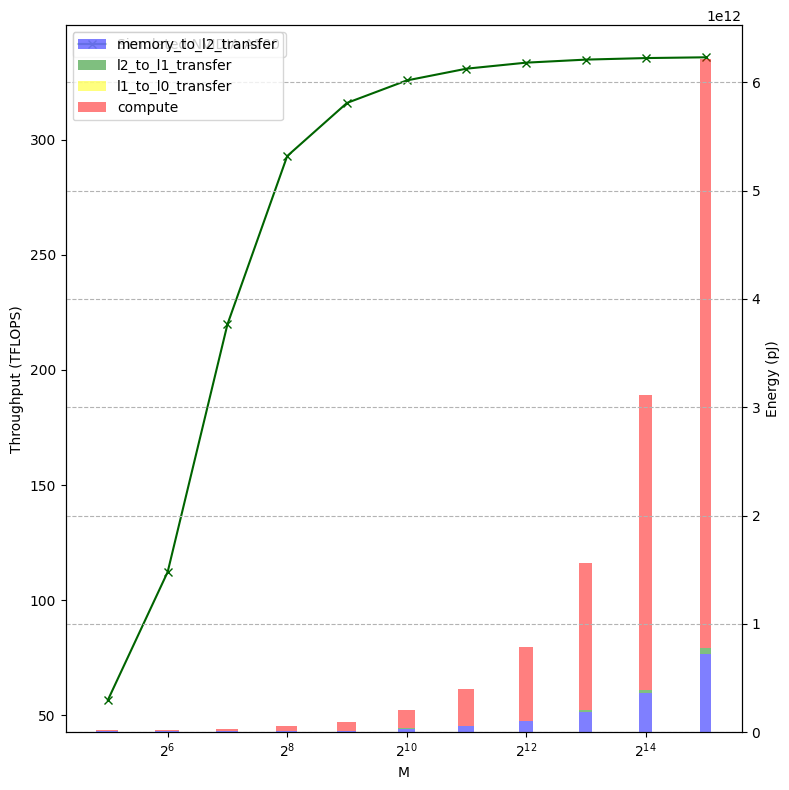

<Figure size 640x480 with 0 Axes>

In [8]:
K = 12288
N = K
title = f"Performance of Matmul with K={K}, N={N}"
M_list = []

throughput_GPU_sim_list = []
energy_GPU_sim_list = [[] for _ in range(4)]
for M in range(5, 16):
    M = 2**M
    M_list.append(M)
    throughput_GPU_sim_list.append(matmul_gpu_sim.loc[(M, N, K), "throughput"])
    energy_GPU_sim_list[0].append(matmul_gpu_sim.loc[(M, N, K), "memory_to_l2_transfer"])
    energy_GPU_sim_list[1].append(matmul_gpu_sim.loc[(M, N, K), "l2_to_l1_transfer"])
    energy_GPU_sim_list[2].append(matmul_gpu_sim.loc[(M, N, K), "l1_to_l0_transfer"])
    energy_GPU_sim_list[3].append(matmul_gpu_sim.loc[(M, N, K), "compute"])

fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.set_xscale("log", base=2)
ax1.set_xlabel("M")

ax1.plot(M_list, throughput_GPU_sim_list, marker="x", label="Simulated NVIDIA A100", color='darkgreen')
ax1.set_ylabel('Throughput (TFLOPS)')

ax2 = ax1.twinx()
#ax2.set_yscale("log")
M_list = np.array(M_list)
bar_widths = ((M_list - 2**4) * 2) / np.log2(M_list - 2**4)
ax2.bar(M_list, energy_GPU_sim_list[0], width=bar_widths, label='memory_to_l2_transfer', color='blue', alpha=0.5)
bottom = energy_GPU_sim_list[0]
ax2.bar(M_list, energy_GPU_sim_list[1], width=bar_widths, bottom=bottom, label='l2_to_l1_transfer', color='green', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[1])]
ax2.bar(M_list, energy_GPU_sim_list[2], width=bar_widths, bottom=bottom, label='l1_to_l0_transfer', color='yellow', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[2])]
ax2.bar(M_list, energy_GPU_sim_list[3], width=bar_widths, bottom=bottom, label='compute', color='red', alpha=0.5)
ax2.set_ylabel('Energy (pJ)')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.grid(True, which="both", ls="--", c="0.7")  # Adding a grid for better readability
plt.tight_layout()
plt.show()
plt.savefig("figure5b.pdf", bbox_inches="tight", pad_inches=0.01, dpi=300)


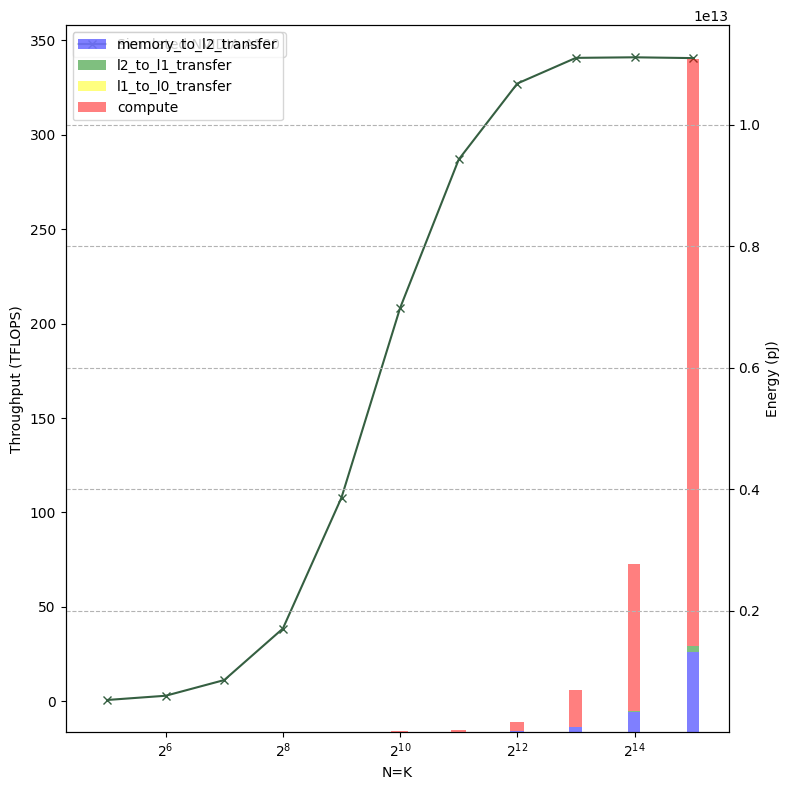

<Figure size 640x480 with 0 Axes>

In [9]:

M = 8192
title = f"Performance of Matmul with M={M}"
K_list = []
throughput_GPU_sim_list = []
energy_GPU_sim_list = [[] for _ in range(4)]
for K in range(5, 16):
    K = 2**K
    N = K
    K_list.append(K)
    throughput_GPU_sim_list.append(matmul_gpu_sim.loc[(M, N, K), "throughput"])
    energy_GPU_sim_list[0].append(matmul_gpu_sim.loc[(M, N, K), "memory_to_l2_transfer"])
    energy_GPU_sim_list[1].append(matmul_gpu_sim.loc[(M, N, K), "l2_to_l1_transfer"])
    energy_GPU_sim_list[2].append(matmul_gpu_sim.loc[(M, N, K), "l1_to_l0_transfer"])
    energy_GPU_sim_list[3].append(matmul_gpu_sim.loc[(M, N, K), "compute"])

fig, ax1 = plt.subplots(figsize=(8, 8))

ax1.set_xscale("log", base=2)
ax1.set_xlabel("N=K")

ax1.plot(M_list, throughput_GPU_sim_list, marker="x", label="Simulated NVIDIA A100", color=color_NV[2])
ax1.set_ylabel('Throughput (TFLOPS)')

ax2 = ax1.twinx()
#ax2.set_yscale("log")
M_list = np.array(M_list)
bar_widths = ((M_list - 2**4) * 2) / np.log2(M_list - 2**4)
ax2.bar(M_list, energy_GPU_sim_list[0], width=bar_widths, label='memory_to_l2_transfer', color='blue', alpha=0.5)
bottom = energy_GPU_sim_list[0]
ax2.bar(M_list, energy_GPU_sim_list[1], width=bar_widths, bottom=bottom, label='l2_to_l1_transfer', color='green', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[1])]
ax2.bar(M_list, energy_GPU_sim_list[2], width=bar_widths, bottom=bottom, label='l1_to_l0_transfer', color='yellow', alpha=0.5)
bottom = [i + j for i, j in zip(bottom, energy_GPU_sim_list[2])]
ax2.bar(M_list, energy_GPU_sim_list[3], width=bar_widths, bottom=bottom, label='compute', color='red', alpha=0.5)
ax2.set_ylabel('Energy (pJ)')

ax1.legend(loc='upper left')
ax2.legend(loc='upper left')

plt.grid(True, which="both", ls="--", c="0.7")  # Adding a grid for better readability
plt.tight_layout()
plt.show()
plt.savefig("figure5a.pdf", bbox_inches="tight", pad_inches=0.01, dpi=300)